In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [87]:
df = pd.read_csv('clientes_data.csv')

Verificamos seu formato e os tipos de dados armazenados para cada cliente

In [88]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [89]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

A coluna Exited é a que tentaremos prever representada por 0 ou 1 sendo uma então um problema de classificação binária

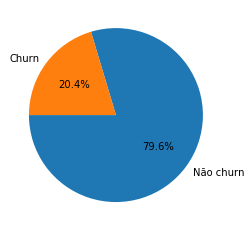

In [90]:
churn_rate = df['Exited'].value_counts()
plt.pie(churn_rate, labels=['Não churn','Churn'],  startangle=180,  autopct='%1.1f%%')
plt.show()

Gráfico demonstra um desbalanceamento de dados

Definimos uma função hist() para criarmos histogramas, assim podemos analisar a correlação de algumas colunas com a quantidade de Churn   

In [91]:
def hist(column):
    plt.hist([df[df.Exited == 0].loc[:, column], df[df.Exited == 1].loc[:, column]], label=['No Churn', 'Churn'])
    plt.legend()
    plt.show()

##### Podemos formular algumas hipóteses analisando estes histogramas:

In [92]:
df['Tenure']

0        2
1        1
2        8
3        1
4        2
        ..
9995     5
9996    10
9997     7
9998     3
9999     4
Name: Tenure, Length: 10000, dtype: int64

A fidelidade do cliente tem uma leve influência em questão de churn

/home/xavier/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


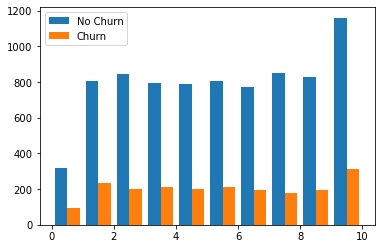

In [93]:
hist('Tenure')

O balanço não parece ter muita influência no churn

In [94]:
df['Balance']

0            0.00
1        83807.86
2       159660.80
3            0.00
4       125510.82
          ...    
9995         0.00
9996     57369.61
9997         0.00
9998     75075.31
9999    130142.79
Name: Balance, Length: 10000, dtype: float64

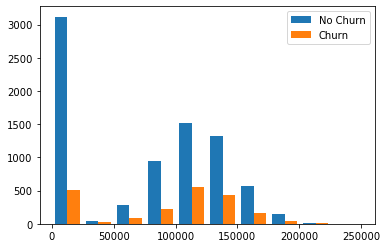

In [95]:
hist('Balance')

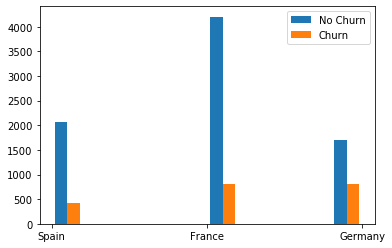

In [96]:
hist('Geography')


In [97]:
df['Age']

0       42
1       41
2       42
3       39
4       43
        ..
9995    39
9996    35
9997    36
9998    42
9999    28
Name: Age, Length: 10000, dtype: int64

Clientes entre 40 e 50 anos possuem uma maior probabilidade de saída

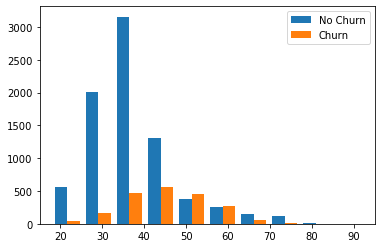

In [98]:
hist('Age')

Clientes com apenas 2 produtos possuem a menor incidência de churn proporcionalmente

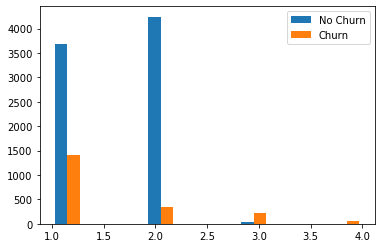

In [99]:
hist('NumOfProducts')

## Tratamento dos dados

Excluindo as colunas RowNumber, CustomerId e Surname. Não são relevantes.

In [100]:
df.drop(df.columns[[0, 1, 2]], axis = 1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [101]:
df.isna().any()

CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [102]:
# Tratando um campo de string para um valor numérico

df['Gender'].replace({'Female':1, 'Male':0}, inplace = True)
df['Gender'].unique()

array([1, 0])

In [103]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [104]:
# Transformando cada valor em uma coluna
df = pd.get_dummies(data=df, columns=['Geography'])
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

Agora todos os valores armazenados na tabela são númericos, facilitando sua aplicação em um modelo preditivo

In [105]:
df.dtypes

CreditScore            int64
Gender                 int64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
dtype: object

No entando, alguns valores ainda precisam ser colocados em escala, isto é, entre 0 e 1. Fazemos isto chamando a função MinMaxScaler() para as colunas que ainda não estão entre 0 e 1.

In [106]:
# Deixando todos colunas na mesma escala
to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = MinMaxScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,1,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0
1,0.516,1,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,0,1
2,0.304,1,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0
3,0.698,1,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0
4,1.000,1,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,0,1


Criamos dois novos DataFrames: "x", contendo os valores de todas as colunas da tabela menos Exited, e "y", contendo os valores da coluna Exited. Isto é necessário para que o modelo possa ser treinado e testado sem saber os valores de Exited préviamente

In [107]:
# Retirando a variável de saída do conjunto de entrada
x = df.drop('Exited', axis='columns')
y = df['Exited']

In [108]:
# Separação entre conjunto de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

# Balanceamento dos dataframes de treinamento com SMOTE
smt = SMOTE(sampling_strategy=1, random_state=100)
x_smote, y_smote = smt.fit_resample(x_train, y_train)

# Criando modelo de Random Forest Classifier
model = RandomForestClassifier()
# Treinando modelo com x_smote e y_smote 
model.fit(x_smote, y_smote)
# Prevendo valores 
y_pred = model.predict(x_test)
# Verificando performance do modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2389
           1       0.62      0.59      0.60       611

    accuracy                           0.84      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.84      0.84      0.84      3000



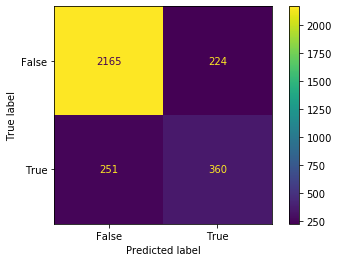

In [109]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()